## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt.plotting as plotting
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

## Getting the Data

In [2]:
start_date = '2022-07-01'
end_date = '2023-06-30'

# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','BABA','GE','AMD','BAC','GM','T','UAA','XOM','RRC','PFE','JPM','SBUX']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  17 of 17 completed


In [3]:
# Download benchmark data - We can also use Buffet's Portfolio as a Benchmark
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


## Applying Markowitz

In [4]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# Efficient Frontier with random portfolios

/home/bhavya/anaconda3/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


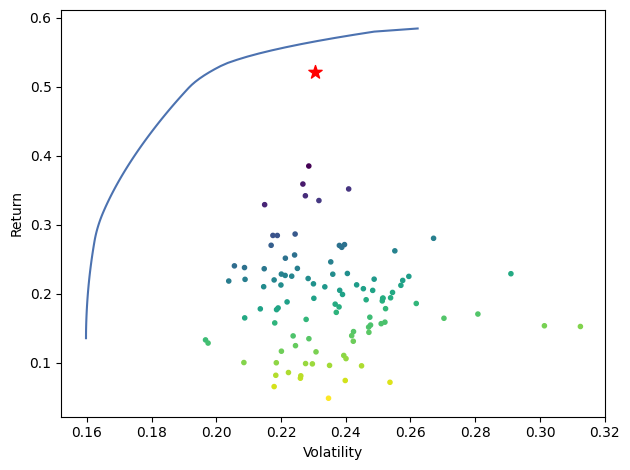

In [5]:
fig, ax = plt.subplots()
ef_optimize = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

### Choosing Optimization Strategy (Comment out the other approach you want to use)

#adding gamma for diversification - https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#l2-regularisation
ef_optimize.add_objective(objective_functions.L2_reg, gamma=1.5)


#For Max Sharpe

ef_optimize.max_sharpe()

# Markowitz with Target Volatility

#target_volatility = 0.2
#ef_optimize.efficient_risk(target_volatility)

# Find the tangency portfolio

ret_tangent, std_tangent, _ = ef_optimize.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
# Normalize weights to sum up to 1 - to make sure they lie within efficient frontier
w = w / np.sum(w, axis=1, keepdims=True)  
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
#ax.set_title("Efficient Frontier with random portfolios")
#ax.legend()
ax.get_legend().remove()
plt.tight_layout()
#Saves the output file as a transparent image
plt.savefig("ef_scatter.png", dpi=200, transparent=True)
plt.show()

In [6]:
# Print Weights - Max Sharpe
cleaned_weights = ef_optimize.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.09902), ('AMD', 0.11224), ('BA', 0.13634), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.2), ('GM', 0.03861), ('GOOG', 0.01643), ('JPM', 0.08353), ('MU', 0.04098), ('PFE', 0.0), ('RRC', 0.03248), ('SBUX', 0.07565), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.08945), ('XOM', 0.07525)])


## Portfolio Performance

In [7]:
#to know the expected performance of the portfolio with optimal weights w
ef_optimize.portfolio_performance(verbose=True)

Expected annual return: 52.2%
Annual volatility: 23.0%
Sharpe Ratio: 2.18


(0.5216830225996397, 0.23036635643857395, 2.1777616764686343)

## Optimal Allocation

In [8]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

/home/bhavya/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [9]:
print("Optimal Allocation:", allocation)

Optimal Allocation: {'AAPL': 5, 'AMD': 10, 'BA': 6, 'GE': 19, 'GM': 10, 'GOOG': 1, 'JPM': 6, 'MU': 6, 'RRC': 11, 'SBUX': 8, 'WMT': 6, 'XOM': 7}


## Comparison with Benchmark Chart

In [10]:
#print(historical_prices)

In [11]:
unique_years = historical_prices.index.year.unique()

#print(unique_years)

In [12]:
# Iterate through each year
for year in unique_years:
    # Filter the DataFrame for the current year
    current_year_prices = historical_prices[historical_prices.index.year == year]
    
    # Perform operations on the current_year_prices
    portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Print the result for the current year
    print(year)

2022
2023


In [13]:
# Calculate portfolio and benchmark returns
portfolio_returns = (historical_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
benchmark_returns = spy_data.pct_change().dropna()

# Calculate returns for the additional year
additional_returns = (additional_year_prices.pct_change().dropna() * additional_cleaned_weights).sum(axis=1)

# Append the additional year's returns to the existing portfolio_returns series
portfolio_returns = portfolio_returns.append(additional_returns)

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
#plt.legend()
#plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy.png', transparent=True)

NameError: name 'additional_year_prices' is not defined

### Hierarchical Risk Parity
HRP is a modern portfolio optimization method inspired by machine learning.

The idea is that by examining the hierarchical structure of the market, we can better diversify.

In [ ]:
rets = expected_returns.returns_from_prices(historical_prices)

In [ ]:
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

In [ ]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [ ]:
hrp.portfolio_performance(verbose=True);

### Plotting

Plotting a dendrogram (tree diagram) based on the hierarchical structure of asset returns

In [ ]:
plotting.plot_dendrogram(hrp); 

## Markowitz with Monthly Rebalancing keeping Original Weights Only

TODO

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months

TODO